In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)
pd.options.mode.chained_assignment = None

In [2]:
'''
PREPROCESSING
'''

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

def clean(df, thresh):

    # DROP SHIT
    df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # CLEAN FURTHER
    lst = ['Mr.','Mrs.','Master.','Miss.']
    count =0
    for i in range(len(df)):
        i += thresh
        
        # EXTRACT NAME
        l = df.Name[i].split(' ')
        for j in l:
            if j.strip() in lst:
                df.Name[i] = j.strip()[:-1]
                count +=1
                break
            df.Name[i] = ''

        # FILL NAME
        if df.Name[i] == '':
            if df.Sex[i]=='male':
                if df.Age[i]>=18:
                    df.Name[i]='Mr'
                else:
                    df.Name[i]='Master'
            elif df.Sex[i]=='female':
                if df.Age[i]>=18:
                    df.Name[i]='Mrs'
                else:
                    df.Name[i]='Miss'

        # FILL AGE
        if not(df.Age[i]>0.001):
            if df.Name[i]=='Mr' or df.Name[i]=='Mrs':
                df.Age[i]=np.random.choice(range(20,50))
            else:
                df.Age[i]=np.random.choice(range(5,18))
        
    # MAKE NUMERIC
    df.replace({'Sex':{'male':0,'female':1}, 'Embarked':{'S':-1,'C':0,'Q':1},\
                'Name':{'Mr':-1,'Mrs':1,'Master':-0.5,'Miss':0.5}}, inplace=True)

In [3]:
# DATASET FUNCTIONS
def get_train_data():
    df = df_train[:720]
    clean(df, 0)
    x = df.drop(['Survived'], axis=1)
    x = (x - x.mean())/(x.max()-x.min())
    y = df.loc[:,'Survived']
    x = x.values
    y = y.values
    y = np.expand_dims(y, axis=1)
    return x,y

def get_val_data():
    df = df_train[720:]
    clean(df, 720)
    x = df.drop(['Survived'], axis=1)
    x = (x - x.mean())/(x.max()-x.min())
    y = df.loc[:,'Survived']
    x = x.values
    y = y.values
    y = np.expand_dims(y, axis=1)
    return x,y

def get_test_data():
    df = df_test
    clean(df, 0)
    x = df
    x = (x - x.mean())/(x.max()-x.min())
    x = x.values
    return x

In [4]:
# DATA
train_data, train_labels = get_train_data()
val_data, val_labels = get_val_data()
test_data = get_test_data()

In [5]:
# CHECK SHAPES
print ('train_data', train_data.shape, 'train_label', train_labels.shape)
print ('val_data', val_data.shape, 'val_label', val_labels.shape)
print ('test_data', test_data.shape)

train_data (720, 8) train_label (720, 1)
val_data (171, 8) val_label (171, 1)
test_data (418, 8)


In [6]:
# TRAINING PARAMETERS                       
num_epochs = 100000
display_epoch = 2000
num_samples = train_data.shape[0]
num_attrib=train_data.shape[1]
batch_size = 16
lr = 1e-4
num_hidden=16

In [7]:
# SIGMOID ACTIVATION AND ITS DERIVATIVE
def activate(x):
    return 1 / (1+np.exp(-x))
def d_activation(x):
    return x * (1-x)

In [8]:
# WEIGHTS AND BIASES
weight_i_h = np.random.random((num_attrib, num_hidden)) - 0.3
weight_h_o = np.random.random((num_hidden,1)) - 0.1
bias_i_h = np.random.random((num_hidden)) + 0.2
bias_h_o = np.random.random((1)) + 0.3

In [9]:
# EMPTY LISTS TO STORE EPOCH, LOSS AND ACCURACY
ep, lo, ac = [], [], []

# TRAINING
for epoch in range(1,num_epochs+1):
    
    for batch in range(num_samples/batch_size):
        
        # FORWARD PROPAGATON
        input_layer = train_data[batch_size*batch: batch_size*(batch+1)]
        hidden_layer = activate(np.dot(input_layer, weight_i_h) + bias_i_h)
        output_layer = activate(np.dot(hidden_layer, weight_h_o) + bias_h_o)
        output_train_labels = train_labels[batch_size*batch: batch_size*(batch+1)]

        loss = output_layer - output_train_labels
        
        # BACKWARD PROPAGATION
        weight_i_h -= lr * input_layer.T.dot(((loss * d_activation(output_layer)).dot(weight_h_o.T)) * d_activation(hidden_layer))
        bias_i_h -= lr * sum(((loss * d_activation(output_layer)).dot(weight_h_o.T)) * d_activation(hidden_layer))
        weight_h_o -= lr * hidden_layer.T.dot(loss * d_activation(output_layer))
        bias_h_o -= lr * sum(loss * d_activation(output_layer))
    
    # ACCURACY
    x_, y_ = train_data[batch_size*batch: batch_size*(batch+1)], train_labels[batch_size*batch: batch_size*(batch+1)]
    prediction = activate((activate(x_.dot(weight_i_h) + bias_i_h)).dot(weight_h_o) + bias_h_o)
    prediction = (np.round(prediction, decimals=0)).astype(int)
    acc = np.mean(np.equal(y_, prediction))
    
    # STORE CHECKPOINTS
    if epoch == 1:
        print ('Training in progress...')
        print ('Epoch:', '%05d' % (epoch), ' Loss: {0:.10f}'.format((sum(abs(loss)))[0]), ' Training Accuracy: {0:.5f}'.format(acc))
    if epoch % display_epoch == 0:
        print ('Epoch:', '%05d' % (epoch), ' Loss: {0:.10f}'.format((sum(abs(loss)))[0]), ' Training Accuracy: {0:.5f}'.format(acc))
        ep.append(epoch)
        lo.append((sum(abs(loss)))[0])
        ac.append(acc)

print ('Model Trained !')

Training in progress...
Epoch: 00001  Loss: 7.9691142798  Training Accuracy: 0.50000
Epoch: 02000  Loss: 5.8902202109  Training Accuracy: 0.81250
Epoch: 04000  Loss: 4.7790904040  Training Accuracy: 0.81250
Epoch: 06000  Loss: 4.4328237113  Training Accuracy: 0.81250
Epoch: 08000  Loss: 4.2514062935  Training Accuracy: 0.81250
Epoch: 10000  Loss: 4.1353998644  Training Accuracy: 0.81250
Epoch: 12000  Loss: 4.0578665582  Training Accuracy: 0.81250
Epoch: 14000  Loss: 4.0051760736  Training Accuracy: 0.81250
Epoch: 16000  Loss: 3.9688953713  Training Accuracy: 0.81250
Epoch: 18000  Loss: 3.9436738170  Training Accuracy: 0.81250
Epoch: 20000  Loss: 3.9260637385  Training Accuracy: 0.81250
Epoch: 22000  Loss: 3.9137820698  Training Accuracy: 0.81250
Epoch: 24000  Loss: 3.9052673809  Training Accuracy: 0.81250
Epoch: 26000  Loss: 3.8994192509  Training Accuracy: 0.81250
Epoch: 28000  Loss: 3.8954433750  Training Accuracy: 0.81250
Epoch: 30000  Loss: 3.8927568501  Training Accuracy: 0.81250


Training Graph --


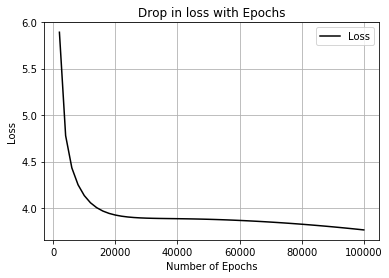

In [10]:
# PLOT
print ('Training Graph --')
plt.plot(ep, lo, 'k-', label = 'Loss')
plt.legend()
plt.title('Drop in loss with Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [11]:
# VALIDATION
val_data, val_label = get_val_data()
prediction = activate((activate(val_data.dot(weight_i_h) + bias_i_h)).dot(weight_h_o) + bias_h_o)
print ('Validation Accuracy --')
prediction = (np.round(prediction, decimals=0)).astype(int)
acc = np.mean(np.equal(val_label, prediction))
print (acc)

Validation Accuracy --
0.859649122807


In [12]:
# TEST
test = test_data
prediction = activate((activate(test.dot(weight_i_h) + bias_i_h)).dot(weight_h_o) + bias_h_o)
print ('Test Predictions --')
prediction = (np.round(prediction, decimals=0)).astype(int)
print (sum(prediction), 'survived out of', len(test_data))

Test Predictions --
[138] survived out of 418
